In [25]:
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import EarthLocation, Angle
from astropy.time import Time
from astropy.table import Table

In [26]:
# Set up times and locations

# Birr
birr_loc = EarthLocation(lat=53.095*u.deg, lon=-7.922*u.deg)
observing_time_start_birr = Time('2024-06-25 07:00:00', scale='utc', location=birr_loc)
observing_time_end_birr = Time('2024-06-26 14:00:00', scale='utc', location=birr_loc)
LST_start_birr = observing_time_start_birr.sidereal_time('mean')
LST_end_birr = observing_time_end_birr.sidereal_time('mean')

# Onsala
onsala_loc = EarthLocation(lat=57.399*u.deg, lon=11.930*u.deg)
observing_time_start_onsala = Time('2024-06-25 07:00:00', scale='utc', location=onsala_loc)
observing_time_end_onsala = Time('2024-06-26 14:00:00', scale='utc', location=onsala_loc)
LST_start_onsala = observing_time_start_onsala.sidereal_time('mean')
LST_end_onsala = observing_time_end_onsala.sidereal_time('mean')

# Midpoint
mid_lon = (birr_loc.lon + onsala_loc.lon)/2
mid_loc = EarthLocation(lat=57.399*u.deg, lon=mid_lon)
observing_time_start_mid = Time('2024-06-25 07:00:00', scale='utc', location=mid_loc)
observing_time_end_mid = Time('2024-06-26 14:00:00', scale='utc', location=mid_loc)
LST_start_mid = observing_time_start_mid.sidereal_time('mean')
LST_end_mid = observing_time_end_mid.sidereal_time('mean')

print('Starting LST in Birr:', LST_start_birr)
print('Starting LST in Onsala:', LST_start_onsala)
print('Starting LST at midpoint:', LST_start_mid)

print('\n')

print('Ending LST in Birr:', LST_end_birr)
print('Ending LST in Onsala:', LST_end_onsala)
print('Ending LST at midpoint:', LST_end_mid)

Starting LST in Birr: 0h43m58.08020632s
Starting LST in Onsala: 2h03m22.56020631s
Starting LST at midpoint: 1h23m40.32020631s


Ending LST in Birr: 7h49m03.63149321s
Ending LST in Onsala: 9h08m28.1114932s
Ending LST at midpoint: 8h28m45.8714932s


In [27]:
# import data and clean it up

# Exoplanet data
data = ascii.read('PS_2024.06.17_03.31.30.csv')
data_unmodified = ascii.read('PS_2024.06.17_03.31.30.csv')
data_coords = ascii.read('PS_2024.06.17_03.31.30.csv')
data.remove_columns(['pl_name', 'hd_name', 'hip_name', 'default_flag', 'sy_mnum', 'cb_flag', 'sy_pnum', 'disc_year', 'disc_refname', 'disc_pubdate', 'disc_locale', 'disc_facility', 'disc_telescope', 'disc_instrument', 'rv_flag', 'pul_flag', 'ptv_flag', 'tran_flag', 'ast_flag', 'obm_flag', 'micro_flag', 'etv_flag', 'ima_flag', 'dkin_flag', 'pl_controv_flag', 'gaia_id', 'pl_refname', 'pl_orbperlim', 'pl_orbsmaxlim', 'soltype', 'pl_radelim', 'pl_radjlim', 'pl_masselim', 'pl_massjlim', 'rowupdate', 'pl_pubdate', 'releasedate', 'pl_nnotes', 'st_nphot', 'st_nrvc', 'st_nspec', 'pl_nespec', 'pl_ntranspec', 'pl_msinie', 'pl_msinieerr1', 'pl_msinieerr2', 'pl_msinielim', 'pl_msinij', 'pl_msinijerr1', 'pl_msinijerr2', 'pl_msinijlim', 'pl_cmasse', 'pl_cmasseerr1', 'pl_cmasseerr2', 'pl_cmasselim', 'pl_cmassj', 'pl_cmassjerr1', 'pl_cmassjerr2', 'pl_cmassjlim', 'pl_bmasse', 'pl_bmasseerr1', 'pl_bmasseerr2', 'pl_bmasselim', 'pl_bmassj', 'pl_bmassjerr1', 'pl_bmassjerr2', 'pl_bmassjlim', 'pl_bmassprov', 'pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_denslim', 'pl_orbeccenlim', 'pl_insollim', 'pl_eqtlim', 'pl_orbincllim', 'pl_tranmid', 'pl_tranmiderr1', 'pl_tranmiderr2', 'pl_tranmidlim', 'pl_tsystemref', 'ttv_flag', 'pl_imppar', 'pl_impparerr1', 'pl_impparerr2', 'pl_impparlim', 'pl_trandep', 'pl_trandeperr1', 'pl_trandeperr2', 'pl_trandeplim', 'pl_trandur', 'pl_trandurerr1', 'pl_trandurerr2', 'pl_trandurlim', 'pl_ratdor', 'pl_ratdorerr1', 'pl_ratdorerr2', 'pl_ratdorlim', 'pl_ratror', 'pl_ratrorerr1', 'pl_ratrorerr2', 'pl_ratrorlim', 'pl_occdep', 'pl_occdeperr1', 'pl_occdeperr2', 'pl_occdeplim', 'pl_orbtper', 'pl_orbtpererr1', 'pl_orbtpererr2', 'pl_orbtperlim', 'pl_orblper', 'pl_orblpererr1', 'pl_orblpererr2', 'pl_orblperlim', 'pl_rvamp', 'pl_rvamperr1', 'pl_rvamperr2', 'pl_rvamplim', 'pl_projobliq', 'pl_projobliqerr1', 'pl_projobliqerr2', 'pl_projobliqlim', 'pl_trueobliq', 'pl_trueobliqerr1', 'pl_trueobliqerr2', 'pl_trueobliqlim', 'st_refname', 'st_spectype', 'st_tefflim', 'st_radlim', 'st_masslim', 'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim', 'st_metratio', 'st_logg', 'st_loggerr1', 'st_loggerr2', 'st_logglim', 'st_age', 'st_ageerr1', 'st_ageerr2', 'st_agelim', 'st_dens', 'st_denserr1', 'st_denserr2', 'st_denslim', 'st_vsin', 'st_vsinerr1', 'st_vsinerr2', 'st_vsinlim', 'st_rotp', 'st_rotperr1', 'st_rotperr2', 'st_rotplim', 'st_radv', 'st_radverr1', 'st_radverr2', 'st_radvlim', 'sy_refname', 'st_lumlim', 'sy_pm', 'sy_pmerr1', 'sy_pmerr2', 'sy_pmra', 'sy_pmraerr1', 'sy_pmraerr2', 'sy_pmdec', 'sy_pmdecerr1', 'sy_pmdecerr2', 'sy_dist', 'sy_disterr1', 'sy_disterr2', 'sy_plx', 'sy_plxerr1', 'sy_plxerr2', 'sy_bmag', 'sy_bmagerr1', 'sy_bmagerr2', 'sy_vmag', 'sy_vmagerr1', 'sy_vmagerr2', 'sy_jmag', 'sy_jmagerr1', 'sy_jmagerr2', 'sy_hmag', 'sy_hmagerr1', 'sy_hmagerr2', 'sy_kmag', 'sy_kmagerr1', 'sy_kmagerr2', 'sy_umag', 'sy_umagerr1', 'sy_umagerr2', 'sy_gmag', 'sy_gmagerr1', 'sy_gmagerr2', 'sy_rmag', 'sy_rmagerr1', 'sy_rmagerr2', 'sy_imag', 'sy_imagerr1', 'sy_imagerr2', 'sy_zmag', 'sy_zmagerr1', 'sy_zmagerr2', 'sy_w1mag', 'sy_w1magerr1', 'sy_w1magerr2', 'sy_w2mag', 'sy_w2magerr1', 'sy_w2magerr2', 'sy_w3mag', 'sy_w3magerr1', 'sy_w3magerr2', 'sy_w4mag', 'sy_w4magerr1', 'sy_w4magerr2', 'sy_gaiamag', 'sy_gaiamagerr1', 'sy_gaiamagerr2', 'sy_icmag', 'sy_icmagerr1', 'sy_icmagerr2', 'sy_tmag', 'sy_tmagerr1', 'sy_tmagerr2', 'sy_kepmag', 'sy_kepmagerr1', 'sy_kepmagerr2'])


data_coords.keep_columns(['pl_name', 'hostname', 'pl_letter', 'ra', 'rastr', 'dec', 'decstr', 'pl_eqt', 'sy_dist'])
data_coords.sort(keys='ra')

# start and stop observing 30 minutes before/after zenith
start_obs = data_coords['ra'] - 7.5
stop_obs = data_coords['ra'] + 7.5

data_coords['start_obs'] = start_obs
data_coords['stop_obs'] = stop_obs

coords_pl = coord.SkyCoord(ra=data_coords['ra']*u.deg, dec=data_coords['dec']*u.deg)

# pulsar data
pulsars = ascii.read('pulsar.csv')
pulsars.remove_columns(['number', 'a'])
pulsars.sort(keys='ra')
coords_psr = coord.SkyCoord(ra=pulsars['ra'], dec=pulsars['dec'], unit=(u.hourangle, u.deg))

start_psr = Angle(pulsars['ra'], u.hourangle).degree - 7.5
stop_psr = Angle(pulsars['ra'], u.hourangle).degree + 7.5

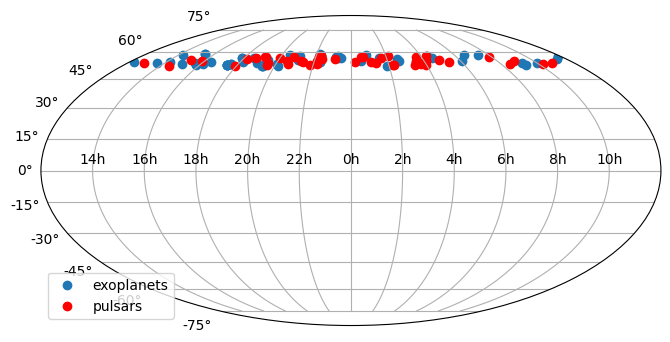

In [28]:
# plot positions
ra = coord.Angle(data_coords['ra']*u.degree)
ra = ra.wrap_at(180*u.degree)
dec = coord.Angle(data_coords['dec']*u.degree)

ra_psr = coords_psr.ra
ra_psr = ra_psr.wrap_at(180*u.degree)
dec_psr = coords_psr.dec

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra.radian, dec.radian, label='exoplanets')
ax.scatter(ra_psr.radian, dec_psr.radian, label='pulsars', color='red')
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend()

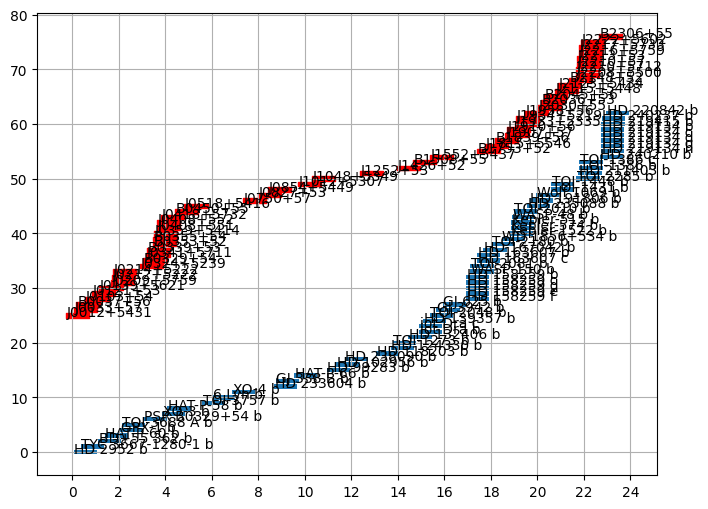

In [29]:
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots(figsize=(8,6))

for i in range(len(start_obs)):
    ax.broken_barh([(start_obs[i], 15)], (i-0.4, 0.8), label=data_coords['pl_name'])
    ax.text(start_obs[i]+0.5, i-0.2, data_coords['pl_name'][i])

for i in range(len(start_psr)):
    ax.broken_barh([(start_psr[i], 15)], (25+i-0.4, 0.8), label=pulsars['name'], color='red')
    ax.text(start_psr[i]+0.5, 25+i-0.2, pulsars['name'][i])

ax.set_xticks(np.arange(0, 361, 30))
ax.set_xticklabels(np.arange(0, 25, 2))
ax.grid(True)

In [30]:
# Take in list of target names, produce list of targets with coords 

targets = ascii.read('targets.csv')
targets.keep_columns(['col1'])


out = Table(names=('target', 'ra', 'dec'), dtype=('str', 'str', 'str'))

for i in range(len(targets)):
    for j in range(len(pulsars['name'])):
        if pulsars['name'][j] == targets['col1'][i]:
            row = pulsars[pulsars['name'] == targets['col1'][i]]
            out.add_row((row['name'], row['ra'], row['dec']))
    for j in range(len(data_coords['pl_name'])):
        if data_coords['pl_name'][j] == targets['col1'][i]:
            row = data_coords[data_coords['pl_name'] == targets['col1'][i]]
            out.add_row((row['pl_name'], row['rastr'], row['decstr']))

In [31]:
out

target,ra,dec
str12,str12,str13
J0139+5621,01:39:38.5,+56:21:36.8
TOI-3688 A b,02h37m07.76s,+54d51m04.37s
B0329+54,03:32:59.4,+54:34:43.3
HAT-P-58 b,04h35m23.16s,+56d52m05.77s
J0518+5416,05:18:53.1,+54:16:50.0
6 Lyn b,06h30m47.05s,+58d09m40.23s
J0750+57,07:50,+57:00
J0854+5449,08:54:25.7,+54:49:28.7
HAT-P-66 b,10h02m17.43s,+53d57m02.97s


In [32]:
# Import schedule csv
schedule = ascii.read('sched.csv')

# Find LST at each site for the UTC values
start_utc = np.asarray(schedule['Start UTC'])
end_utc = np.asarray(schedule['End UTC'])

start_date = np.asarray(schedule['Start Date'])
end_date = np.asarray(schedule['End Date'])

start_lst = np.array([])
end_lst = np.array([])
start_lst_birr = np.array([])
end_lst_birr = np.array([])
start_lst_onsala = np.array([])
end_lst_onsala = np.array([])


for i in range(len(start_utc)):
    start_lst = np.append(start_lst, Time(str(start_date[i]) + ' ' + str(start_utc[i]), format='iso', scale='utc', location=mid_loc).sidereal_time('mean').value)
    end_lst = np.append(end_lst, Time(str(end_date[i]) + ' ' + str(end_utc[i]), format='iso', scale='utc', location=mid_loc).sidereal_time('mean').value)
    start_lst_birr = np.append(start_lst_birr, Time(str(start_date[i]) + ' ' + str(start_utc[i]), format='iso', scale='utc', location=birr_loc).sidereal_time('mean').value)
    end_lst_birr = np.append(end_lst_birr, Time(str(end_date[i]) + ' ' + str(end_utc[i]), format='iso', scale='utc', location=birr_loc).sidereal_time('mean').value)
    start_lst_onsala = np.append(start_lst_onsala, Time(str(start_date[i]) + ' ' + str(start_utc[i]), format='iso', scale='utc', location=onsala_loc).sidereal_time('mean').value)
    end_lst_onsala = np.append(end_lst_onsala, Time(str(end_date[i]) + ' ' + str(end_utc[i]), format='iso', scale='utc', location=onsala_loc).sidereal_time('mean').value)

# Get coords of targets into same style
ra = np.asarray(schedule['RA'])
dec = np.asarray(schedule['DEC'])

c = coord.SkyCoord(ra, dec, unit=(u.hourangle, u.deg))

ra_out = c.ra.rad
dec_out = c.dec.rad

In [33]:
# Output a schedule
sched_out = Table([schedule['ï»¿Name'], start_utc, end_utc, start_lst_birr, end_lst_birr, start_lst_onsala, end_lst_onsala, start_lst, end_lst, ra_out, dec_out], names=('target', 'start_utc', 'end_utc', 'start_lst_birr', 'stop_lst_birr', 'start_lst_onsala', 'stop_lst_onsala', 'start_lst_mid', 'stop_lst_mid', 'ra', 'dec'))

ascii.write(sched_out, 'sched_out.csv', overwrite=True, delimiter=',')